# Análise de Marcha
**Bruno da Silva Cunha**

Universidade Federal do Espírio Santo

**1. Transformação de Dados**

Este notebook é responsável pelo carregamento, transformação e limpeza dos dados, para que sejam utilizados na geração dos keyframes

## Inicializando

In [ ]:
!pip install -U yt-dlp

In [ ]:
from google.colab import drive


Abaixo as constantes que serão utilizadas nesta seção

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha"

As informações serão compartilhadas entre os Collabs pelo drive, então será necessário acessá-lo

In [ ]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Acessar a pasta onde contém todos os arquivos
%cd {BASE_PATH}
!ls

/content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha
data  notebooks  processed


## Carregamento dos dados

In [ ]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Caminho onde estão os CSVs originais
RAW_DATA_PATH = BASE_PATH + "/data/raw"

In [ ]:
#Lista os arquivos da pasta
files = glob.glob(os.path.join(RAW_DATA_PATH, "*.csv"))

# Lê e concatena todos em um único DataFrame
dfs = []
for filex in files:
    print(f"Lendo {filex}...")
    df = pd.read_csv(filex, sep=",")
    dfs.append(df)

# Junta tudo em um único DataFrame
df = pd.concat(dfs, ignore_index=True)

# Exibe o resultado
print(df.shape)
df.head()
droped = False


Lendo /content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/data/raw/GAVD_Clinical_Annotations_2.csv...
Lendo /content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/data/raw/GAVD_Clinical_Annotations_3.csv...
Lendo /content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/data/raw/GAVD_Clinical_Annotations_4.csv...
Lendo /content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/data/raw/GAVD_Clinical_Annotations_5.csv...
Lendo /content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/data/raw/GAVD_Clinical_Annotations_1.csv...
(458116, 10)


/tmp/ipython-input-420250713.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filex, sep=",")


## Transformação dos dados

In [ ]:
from sklearn.utils import resample
import yt_dlp
import time
from tqdm import tqdm



Antes de realizar a limpeza nos dados, será analisado a estrutura dos dados

(348, 10)


<Axes: title={'center': 'Distribuição de vídeos por gait_pat'}, xlabel='gait_pat'>

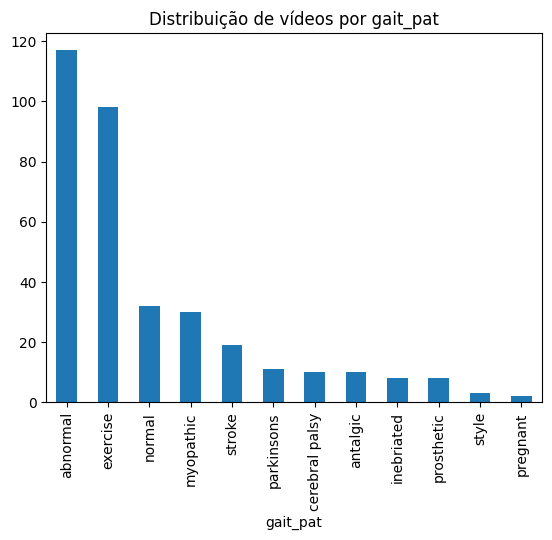

In [ ]:
# manter uma linha por vídeo
df_videos = df.groupby('id', as_index=False).first()

# ver distribuição por classe
print(df_videos.shape)
dist = df_videos['gait_pat'].value_counts()
dist.plot(kind='bar', title='Distribuição de vídeos por gait_pat')

As classes exercise e abnormal são nomenclaturas muito vagas, e estão desbalanceadas em relação as outras classes, podendo viciar o modelo.

No código abaixo será removido as linhas que possui 'exercise' ou 'abnormal'

(133, 10)


<Axes: title={'center': 'Distribuição de vídeos por gait_pat'}, xlabel='gait_pat'>

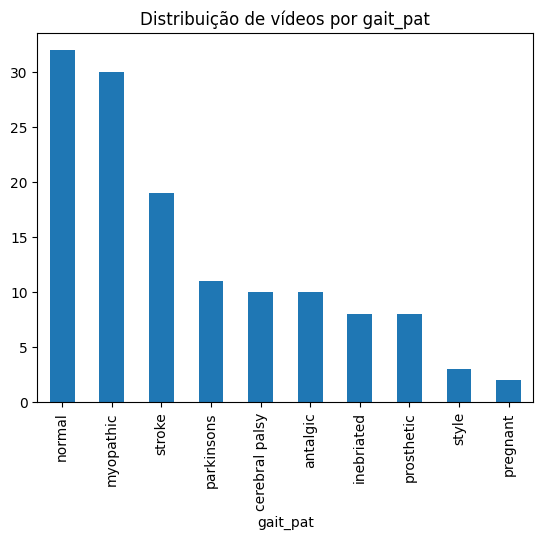

In [ ]:
# Remover linhas onde 'gait_pat' é 'exercise' ou 'abnormal'
df_balanced = df_videos[~df_videos['gait_pat'].isin(['exercise', 'abnormal'])]

# Exibir o resultado
print(df_balanced.shape)
dist = df_balanced['gait_pat'].value_counts()
dist.plot(kind='bar', title='Distribuição de vídeos por gait_pat')

Recuperar no dataset original os ID's após o balanceamento

In [ ]:
# Selecionar paenas os ids balanceados anteriormente
ids_balanceados = df_balanced['id'].unique()
df = df[df['id'].isin(ids_balanceados)]

Realizar o tratamento dos dados, removendo colunas que não terão uso. Pegando apenas vídeos com camera lateral, e calcular o frame minimo e maximo de cada video

In [ ]:
# Remover colunas que não serão úteis
if droped is False:
  df.drop(columns=['vid_info', 'bbox', 'gait_event', 'dataset'], inplace=True)
  droped = True

# Padronizar labels e filtrar apenas visão lateral
df['gait_pat'] = df['gait_pat'].str.strip().str.lower()
df = df[df['cam_view'].str.contains('side|lateral', case=False, na=False)]

# Calcular o frame maximo e minimo da marcha de cada sequencia
# Algumas vezes um vídeo pode ter diferentes poses, então a coluna seq determina
df['min_frame'] = df.groupby('seq')['frame_num'].transform('min')
df['max_frame'] = df.groupby('seq')['frame_num'].transform('max')

# Manter apenas uma sequencia por video
df.drop_duplicates(subset=['seq'], inplace=True)
df



,seq,frame_num,cam_view,gait_pat,id,url,min_frame,max_frame
3828,cljvwb1h6001p3n6l138k9qo4,484,left side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,484,809
4154,cljvwbtul001t3n6lu4qeic4a,889,left side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,889,1138
4824,cljvwe0ky00213n6l7qczieno,5115,right side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,5115,5378
5227,cljvwfmxb00293n6lyo0ffqwb,5761,right side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,5761,6148
6214,cljvwitht002p3n6ltwn2u183,7103,left side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,7103,7348
...,...,...,...,...,...,...,...,...
449000,cljr6wkld00193n6ltjloqzl1,469,left side,myopathic,9qg-3smwLcs,https://www.youtube.com/watch?v=9qg-3smwLcs,469,732
449264,cljr6xqvi001d3n6lctvtihw2,736,right side,myopathic,9qg-3smwLcs,https://www.youtube.com/watch?v=9qg-3smwLcs,736,1190
449719,cljr6z0uo001h3n6lixdz25qa,1193,left side,myopathic,9qg-3smwLcs,https://www.youtube.com/watch?v=9qg-3smwLcs,1193,1439
449966,cljr6zqwu001l3n6lc40rmemx,1486,left side,myopathic,9qg-3smwLcs,https://www.youtube.com/watch?v=9qg-3smwLcs,1486,1907


In [ ]:
print("Quantidade de vídeos unicos:")
df.groupby("id").first().count()

Quantidade de vídeos unicos:


,0
seq,69
frame_num,69
cam_view,69
gait_pat,69
url,69
min_frame,69
max_frame,69
get_info_success,69
fps,69
start_time,69


Importante verificar se o vídeo do youtube ainda está disponível para visualização, caso não esteja, será removido do dataframe

In [ ]:
# Busca algumas informacoes do video
def get_video_info(url: str):
  ydl_opts = {
    "quiet": True,
    "skip_download": True,
    "cookiefile": "/content/cookies.txt"
  }
  try:
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
      info = ydl.extract_info(url, download=False)
    return info

  except yt_dlp.utils.DownloadError as e:
    err_msg = str(e).lower()

    # casos de vídeo inexistente / privado / indisponível permanentemente
    if any(x in err_msg for x in [
        "video unavailable",
        "private video",
        "this video is private",
        "this video is no longer available",
        "sign in to confirm",
        "copyright",
        "404",
    ]):
        return {"status": "not_available", "error": err_msg}

    # erros temporários (rede, quota, captcha, bloqueio)
    if any(x in err_msg for x in [
        "http error",
        "incomplete data",
        "network is unreachable",
        "timeout",
        "too many requests",
        "rate limit",
        "sign in to confirm you’re not a bot",
    ]):
        return {"status": "temporary_error", "error": err_msg}

    # fallback — erro genérico
    return {"status": "unknown_error", "error": err_msg}

  except Exception as e:
    return {"status": "unexpected_error", "error": str(e)}

In [ ]:
# garante a coluna antes de iterar
if "get_info_success" not in df.columns:
  df["get_info_success"] = None

ids_remover = set() # Armazena ids indisponiveis

# Cria um DataFrame com apenas 1 linha por vídeo
unique_videos = df.groupby("id").first().reset_index()

for index, row in tqdm(unique_videos.iterrows(), total=len(unique_videos)):
  if index % 10 == 0:
    print(f"Processados: {index} vídeos...")

  # Verifica se foi marcado para remover, para nao realizar o processamento novamente
  if row["id"] in ids_remover:
    continue

  if row["get_info_success"] is True:
    continue

  info = get_video_info(row['url'])
  time.sleep(1)

  if info is None:
    ids_remover.add(row["id"])
    df.loc[df["id"] == row["id"], "get_info_success"] = False
  elif info.get("status") == "not_available":
    # vídeo inexistente / privado
    ids_remover.add(row["id"])
    df.loc[df["id"] == row["id"], "get_info_success"] = False
  elif info.get("status") == "temporary_error":
    # erro temporário → marcar p/ reprocessar depois
    df.loc[df["id"] == row["id"], "get_info_success"] = None
    print(f"Tentar novamente depois: {row['url']}")
  elif info.get("status") == "unknown_error":
    df.loc[df["id"] == row["id"], "get_info_success"] = None
  else:
    fps = info.get('fps') or 30.0
    df.loc[df["id"] == row["id"], "get_info_success"] = True
    df.loc[df["id"] == row["id"], "fps"] = fps


# remove todas as linhas que tenham esse id
df = df[~df["id"].isin(ids_remover)].reset_index(drop=True)

print("Novo shape:", df.shape)
print("Vídeos indisponíveis:", len(ids_remover))
df.head()


  0%|          | 0/71 [00:00<?, ?it/s]

Processados: 0 vídeos...


 14%|█▍        | 10/71 [00:55<05:07,  5.05s/it]

Processados: 10 vídeos...


 28%|██▊       | 20/71 [01:56<05:00,  5.90s/it]

Processados: 20 vídeos...


 42%|████▏     | 30/71 [02:49<03:49,  5.59s/it]

Processados: 30 vídeos...


 56%|█████▋    | 40/71 [03:36<02:21,  4.56s/it]

Processados: 40 vídeos...


 70%|███████   | 50/71 [04:28<01:44,  4.99s/it]

Processados: 50 vídeos...


 85%|████████▍ | 60/71 [05:20<00:55,  5.05s/it]

Processados: 60 vídeos...


 99%|█████████▊| 70/71 [06:09<00:04,  4.21s/it]

Processados: 70 vídeos...


100%|██████████| 71/71 [06:14<00:00,  5.28s/it]

Novo shape: (446, 10)
Vídeos indisponíveis: 2


,seq,frame_num,cam_view,gait_pat,id,url,min_frame,max_frame,get_info_success,fps
0,cljvwb1h6001p3n6l138k9qo4,484,left side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,484,809,True,30.0
1,cljvwbtul001t3n6lu4qeic4a,889,left side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,889,1138,True,30.0
2,cljvwe0ky00213n6l7qczieno,5115,right side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,5115,5378,True,30.0
3,cljvwfmxb00293n6lyo0ffqwb,5761,right side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,5761,6148,True,30.0
4,cljvwitht002p3n6ltwn2u183,7103,left side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,7103,7348,True,30.0


Exibir os vídeos que apresentaram erro, caso tenha valor diferente de True, se faz necesário rodar o bloco de processamento novamente, para tentar pegar os vídeos que deram erro

In [ ]:
df.value_counts('get_info_success')

,count
get_info_success,
True,446


In [ ]:
# Calcula o tempo inicial e final do video que contém a marcha
df['start_time'] = (df['min_frame'] / df['fps']).round(3)
df['end_time'] = (df['max_frame'] / df['fps']).round(3)
df.head()

,seq,frame_num,cam_view,gait_pat,id,url,min_frame,max_frame,get_info_success,fps,start_time,end_time
0,cljvwb1h6001p3n6l138k9qo4,484,left side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,484,809,True,30.0,16.133,26.967
1,cljvwbtul001t3n6lu4qeic4a,889,left side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,889,1138,True,30.0,29.633,37.933
2,cljvwe0ky00213n6l7qczieno,5115,right side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,5115,5378,True,30.0,170.500,179.267
3,cljvwfmxb00293n6lyo0ffqwb,5761,right side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,5761,6148,True,30.0,192.033,204.933
4,cljvwitht002p3n6ltwn2u183,7103,left side,cerebral palsy,338R10fA_wU,https://www.youtube.com/watch?v=338R10fA_wU,7103,7348,True,30.0,236.767,244.933


In [ ]:
# Caminho para salvar o arquivo processado
PROCESSED_DATA_PATH = BASE_PATH + "/data"

# Salvar o DataFrame processado em um arquivo CSV
output_file_path = os.path.join(PROCESSED_DATA_PATH, "processed_gait_data.csv")
df.to_csv(output_file_path, index=False)

print(f"DataFrame salvo em: {output_file_path}")

DataFrame salvo em: /content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/data/processed_gait_data.csv


446 vídeos de marcha lateral

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq               446 non-null    object 
 1   frame_num         446 non-null    int64  
 2   cam_view          446 non-null    object 
 3   gait_pat          446 non-null    object 
 4   id                446 non-null    object 
 5   url               446 non-null    object 
 6   min_frame         446 non-null    int64  
 7   max_frame         446 non-null    int64  
 8   get_info_success  446 non-null    object 
 9   fps               446 non-null    float64
 10  start_time        446 non-null    float64
 11  end_time          446 non-null    float64
dtypes: float64(3), int64(3), object(6)
memory usage: 41.9+ KB
